### Loaing Necessary Libraries

In [2]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Reading Image Info from CSV and Cleaning

In [3]:
df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr'])
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [4]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1},
            'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}})

In [5]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

# Image Modelling

### Loading Images

In [6]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = '../input/memotion-dataset-7k/memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 93%|█████████▎| 6500/6987 [03:18<00:04, 106.05it/s]/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 96%|█████████▌| 6673/6987 [03:20<00:02, 109.78it/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6987/6987 [03:24<00:00, 34.22it/s] 


In [7]:
X.shape

(6982, 100, 100, 3)

### Dropping few rows to make shape consistent

In [8]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [9]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [10]:
Y = cleaned.iloc[:,2:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [11]:
Y = cleaned.iloc[:,2:]

In [12]:
y_train

,humour,sarcasm,offensive,motivational,overall_sentiment
2998,3,0,0,0,1
3082,0,2,1,0,2
67,1,1,1,0,3
4127,3,2,0,0,3
4288,1,1,0,0,3
...,...,...,...,...,...
447,2,1,1,0,1
6205,2,2,2,0,2
2313,3,2,0,0,2
1379,1,3,1,0,3


### Image Preprocessing

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### Base Model

In [14]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 3s 0us/step


In [15]:
base_model_1.trainable = False
base_model_2.trainable = False

### Model for Image

In [16]:
image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
image_layers = data_augmentation(image_input)
image_layers = preprocess_input(image_layers)
layer_bm_1 = base_model_1(image_input, training=False)
layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
layer_bm_1 = Dense(512)(layer_bm_1)
layer_bm_2 = base_model_2(image_input, training=False)
layer_bm_2 = Dense(512)(layer_bm_2)
layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
image_layers = GlobalAveragePooling2D()(layers)
image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)

# Text Modelling

### Standardization and Cleaning

In [17]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned.text_corrected)

### Vectorizing Layers

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 100000
sequence_length = 50

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [19]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text_corrected, Y, test_size = 0.2)

In [20]:
embedding_dim=32

text_input = tf.keras.Input(shape=(None,), dtype=tf.string, name='text')
text_layers = vectorize_layer(text_input)
text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(text_layers)
text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(text_layers)

text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

# Combining and Evaluating

### Concatenating Layers

In [21]:
concatenate = tf.keras.layers.concatenate([image_layers, text_layers], axis=1)
semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'humuor')
prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
prediction_layer_4 = tf.keras.layers.Dense(1, activation='sigmoid', name = 'motivational')
prediction_layer_5 = tf.keras.layers.Dense(5, activation='softmax', name = 'overall')

output_1 = prediction_layer_1(semi_final_layer)
output_2 = prediction_layer_2(semi_final_layer)
output_3 = prediction_layer_3(semi_final_layer)
output_4 = prediction_layer_4(semi_final_layer)
output_5 = prediction_layer_5(semi_final_layer)

model = tf.keras.Model(inputs = [image_input, text_input] , 
                       outputs = [output_1, output_2, output_3, output_4, output_5])

In [22]:
base_learning_rate = 0.001
losses = {
      "humuor": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "sarcasm": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "offensive": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "motivational": tf.keras.losses.BinaryCrossentropy(from_logits=False),
      "overall": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
lossWeights = {
      "humuor": 1.0, 
      "sarcasm": 1.0, 
      "offensive": 1.0, 
      "motivational": 1.0,
      "overall": 1.0
}
metric = {
    "humuor": ['sparse_categorical_accuracy'],
    "sarcasm": ['sparse_categorical_accuracy'],
    "offensive": ['sparse_categorical_accuracy'],
    "motivational": ['binary_accuracy'],
    "overall": ['sparse_categorical_accuracy']
}

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metric)

In [23]:
history = model.fit(x = {"image_input": X_train, "text_input": X_text_train},
                    y = {"sarcasm": y_train.sarcasm, 
                         "humuor": y_train.humour, 
                         "offensive": y_train.offensive, 
                         "motivational": y_train.motivational, 
                         "overall": y_train.overall_sentiment},
                    batch_size=32,
                    epochs=1,
                    verbose=1
                   )

175/175 [==============================] - 48s 276ms/step - loss: 6.3645 - sarcasm_loss: 1.3638 - humuor_loss: 1.3774 - offensive_loss: 1.3653 - motivational_loss: 0.6724 - overall_loss: 1.5856 - sarcasm_sparse_categorical_accuracy: 0.4836 - humuor_sparse_categorical_accuracy: 0.3388 - offensive_sparse_categorical_accuracy: 0.3921 - motivational_binary_accuracy: 0.6496 - overall_sparse_categorical_accuracy: 0.4500


In [24]:
history = model.evaluate(x = {"image_input": X_test, "text_input": X_text_test},
                    y = {"sarcasm": y_test.sarcasm, 
                         "humuor": y_test.humour, 
                         "offensive": y_test.offensive, 
                         "motivational": y_test.motivational, 
                         "overall": y_test.overall_sentiment},
                    batch_size=32,
                    verbose=1
                   )

44/44 [==============================] - 3s 64ms/step - loss: 6.2911 - sarcasm_loss: 1.3433 - humuor_loss: 1.3673 - offensive_loss: 1.3518 - motivational_loss: 0.6637 - overall_loss: 1.5649 - sarcasm_sparse_categorical_accuracy: 0.5011 - humuor_sparse_categorical_accuracy: 0.3536 - offensive_sparse_categorical_accuracy: 0.3629 - motivational_binary_accuracy: 0.6385 - overall_sparse_categorical_accuracy: 0.4345


**Data Balancing**

Class distribution for humour:

1    2450
2    2235
0    1647
3     650
Name: humour, dtype: int64 



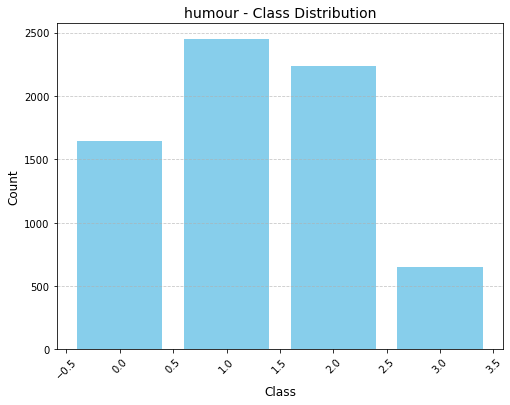

Class distribution for sarcasm:

1    3503
2    1543
0    1542
3     394
Name: sarcasm, dtype: int64 



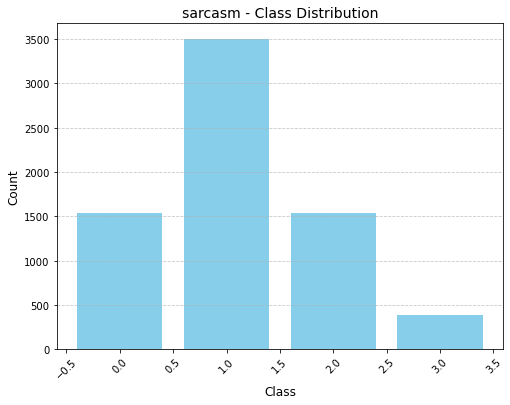

Class distribution for offensive:

0    2707
1    2590
2    1464
3     221
Name: offensive, dtype: int64 



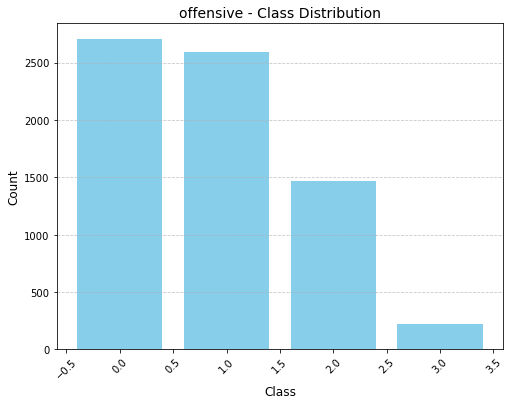

Class distribution for motivational:

0    4520
1    2462
Name: motivational, dtype: int64 



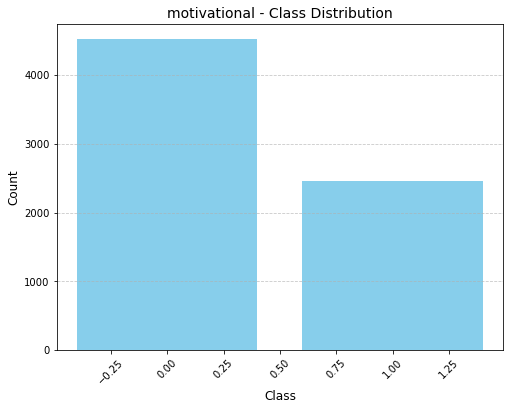

Class distribution for overall_sentiment:

3    3121
2    2198
4    1032
1     480
0     151
Name: overall_sentiment, dtype: int64 



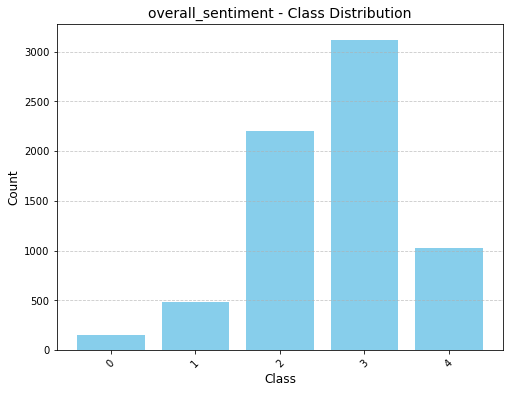

In [25]:
import matplotlib.pyplot as plt

# Function to plot class distributions
def plot_class_distribution(data, column, title):
    class_counts = data[column].value_counts()
    class_labels = class_counts.index
    class_values = class_counts.values

    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.title(f"{title} - Class Distribution", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Check for balance in each target column
target_columns = ['humour', 'sarcasm', 'offensive', 'motivational', 'overall_sentiment']

for column in target_columns:
    print(f"Class distribution for {column}:\n")
    print(cleaned[column].value_counts(), "\n")
    plot_class_distribution(cleaned, column, column)


In [26]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Example of balancing a single target column (e.g., 'humour')
def balance_dataset(df, target_column):
    print(f"Original class distribution for {target_column}:\n")
    print(df[target_column].value_counts(), "\n")
    
    # Separate the dataset into majority and minority classes
    classes = df[target_column].unique()
    majority_class = df[target_column].value_counts().idxmax()
    majority_class_size = df[target_column].value_counts().max()

    balanced_dataframes = []

    # Resample each class to match the size of the majority class
    for cls in classes:
        class_df = df[df[target_column] == cls]
        if len(class_df) < majority_class_size:
            resampled_class_df = resample(
                class_df,
                replace=True,  # Allow resampling with replacement
                n_samples=majority_class_size,
                random_state=42  # Ensure reproducibility
            )
        else:
            resampled_class_df = class_df
        
        balanced_dataframes.append(resampled_class_df)

    # Concatenate all balanced classes
    balanced_df = pd.concat(balanced_dataframes)
    print(f"Balanced class distribution for {target_column}:\n")
    print(balanced_df[target_column].value_counts(), "\n")

    return balanced_df

# Apply to all target columns
target_columns = ['humour', 'sarcasm', 'offensive', 'motivational', 'overall_sentiment']
balanced_dfs = {}

for column in target_columns:
    balanced_dfs[column] = balance_dataset(cleaned, column)

# Optionally combine into one DataFrame if needed
balanced_cleaned = pd.concat([balanced_dfs[col] for col in target_columns]).drop_duplicates()

# Print the final balanced dataset
print(f"Final balanced dataset size: {balanced_cleaned.shape}")

Original class distribution for humour:

1    2450
2    2235
0    1647
3     650
Name: humour, dtype: int64 

Balanced class distribution for humour:

3    2450
2    2450
1    2450
0    2450
Name: humour, dtype: int64 

Original class distribution for sarcasm:

1    3503
2    1543
0    1542
3     394
Name: sarcasm, dtype: int64 

Balanced class distribution for sarcasm:

3    3503
2    3503
1    3503
0    3503
Name: sarcasm, dtype: int64 

Original class distribution for offensive:

0    2707
1    2590
2    1464
3     221
Name: offensive, dtype: int64 

Balanced class distribution for offensive:

3    2707
2    2707
1    2707
0    2707
Name: offensive, dtype: int64 

Original class distribution for motivational:

0    4520
1    2462
Name: motivational, dtype: int64 

Balanced class distribution for motivational:

1    4520
0    4520
Name: motivational, dtype: int64 

Original class distribution for overall_sentiment:

3    3121
2    2198
4    1032
1     480
0     151
Name: overall_sent

In [27]:
print(df.columns)

Index(['image_name', 'text_corrected', 'humour', 'sarcasm', 'offensive',
       'motivational', 'overall_sentiment'],
      dtype='object')


**Sentiment CLassification**

 93%|█████████▎| 6360/6830 [00:49<00:04, 117.15it/s]/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 96%|█████████▌| 6529/6830 [00:50<00:01, 152.48it/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6830/6830 [00:52<00:00, 129.28it/s]


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 100, 100, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 50)           0           text_input[0][0]                 
_______________________________________________________________________________________

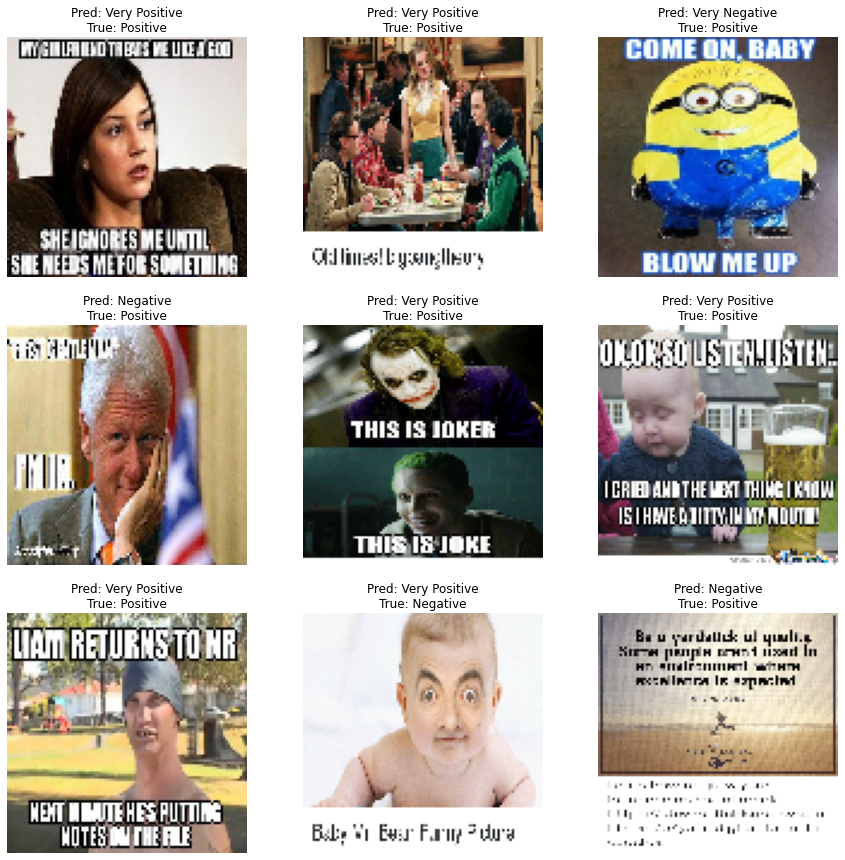

In [28]:
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input, Embedding, LSTM, Bidirectional, 
                                     GlobalMaxPooling1D, GlobalAveragePooling2D)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization, Rescaling, RandomFlip, RandomRotation

# Load dataset
df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df = df.replace({
    'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}
})
df.dropna(inplace=True)

# Text Standardization
def standardize_text(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

df['text_corrected'] = standardize_text(df.text_corrected)

# Image Preprocessing
width, height = 100, 100
X_images = []

for i in tqdm(range(df.shape[0])):
    path = '../input/memotion-dataset-7k/memotion_dataset_7k/images/' + df.iloc[i]['image_name']
    img = image.load_img(path, target_size=(width, height, 3))
    img = image.img_to_array(img) / 255.0
    X_images.append(img)

X_images = np.array(X_images)
y = df['overall_sentiment'].values

# Train-Test Split with Stratification
X_train_images, X_test_images, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X_images,
    y,
    df['text_corrected'].values,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Convert to NumPy array for TextVectorization
X_train_text = np.array(X_train_text)
X_test_text = np.array(X_test_text)

# Text Vectorization
vocab_size = 100000
sequence_length = 50
vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train_text)

# Data Augmentation for Images
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

# Model Definition
preprocess_input = Rescaling(1./127.5, offset=-1)

# Image Model
base_model_resnet = ResNet50(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model_resnet.trainable = True

for layer in base_model_resnet.layers[:-50]:  # Fine-tune last 50 layers
    layer.trainable = False

image_input = Input(shape=(width, height, 3), name='image_input')
x = data_augmentation(image_input)
x = preprocess_input(x)
x = base_model_resnet(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.4)(x)

# Text Model
text_input = Input(shape=(None,), dtype=tf.string, name='text_input')
y = vectorize_layer(text_input)
y = Embedding(vocab_size, 300)(y)  # Increased embedding dimensions
y = Bidirectional(LSTM(256, return_sequences=True))(y)  # Increased LSTM capacity
y = GlobalMaxPooling1D()(y)
y = Dense(128, activation='relu', kernel_regularizer='l2')(y)
y = Dropout(0.4)(y)

# Concatenate Features
concatenated = tf.keras.layers.concatenate([x, y])
z = Dense(512, activation='relu')(concatenated)
z = Dropout(0.5)(z)
output = Dense(5, activation='softmax', name='sentiment')(z)

model = Model(inputs=[image_input, text_input], outputs=[output])
model.compile(optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Custom TensorBoard Callback to Avoid AttributeError
class CustomTensorBoard(TensorBoard):
    def _log_weights(self, epoch):
        try:
            super()._log_weights(epoch)
        except AttributeError:
            pass

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_best.tf', save_best_only=True, monitor='val_loss', save_format='tf')
tensorboard = CustomTensorBoard(log_dir='./logs', histogram_freq=1)

# Model Summary
model.summary()
plot_model(model, show_shapes=True)

# Training with Class Weights
history = model.fit(
    x={"image_input": X_train_images, "text_input": X_train_text},
    y=y_train,
    validation_split=0.2,
    epochs=50,  # Increased epochs
    batch_size=32,  # Moderate batch size
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop, checkpoint, tensorboard]
)

# Evaluation
results = model.evaluate(
    x={"image_input": X_test_images, "text_input": X_test_text},
    y=y_test,
    batch_size=32,
    verbose=1
)
print("Test Accuracy:", results[1])

# Visualization of Results
class_names = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

def visualize_predictions(images, texts, labels, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        pred_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[labels[i]]
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')
    plt.show()

# Predict and Visualize
predictions = model.predict({"image_input": X_test_images[:9], "text_input": X_test_text[:9]})
visualize_predictions(X_test_images[:9], X_test_text[:9], y_test[:9], predictions, class_names=class_names)


In [29]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input, Embedding, LSTM, Bidirectional, 
                                     GlobalMaxPooling1D, GlobalAveragePooling2D)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization, Rescaling, RandomFlip, RandomRotation

# Load dataset
df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df = df.replace({
    'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}
})
cleaned = df.copy()
cleaned.dropna(inplace=True)

# Text Standardization
def standardize_text(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardize_text(cleaned.text_corrected)

# Image Preprocessing
width, height = 100, 100
X_images = []

for i in tqdm(range(cleaned.shape[0])):
    path = '../input/memotion-dataset-7k/memotion_dataset_7k/images/' + cleaned.iloc[i]['image_name']
    img = image.load_img(path, target_size=(width, height, 3))
    img = image.img_to_array(img) / 255.0
    X_images.append(img)

X_images = np.array(X_images)
y = cleaned['overall_sentiment'].values

# Train-Test Split with Stratification
X_train_images, X_test_images, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X_images,
    y,
    cleaned['text_corrected'].values,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Convert to NumPy array for TextVectorization
X_train_text = np.array(X_train_text)
X_test_text = np.array(X_test_text)

# Text Vectorization
vocab_size = 100000
sequence_length = 50
vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train_text)

# Data Augmentation for Images
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

# Model Definition
preprocess_input = Rescaling(1./127.5, offset=-1)

# Image Model
base_model_resnet = ResNet50(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model_resnet.trainable = True  # Unfreeze layers

for layer in base_model_resnet.layers[:-50]:  # Fine-tune last 50 layers
    layer.trainable = False

image_input = Input(shape=(width, height, 3), name='image_input')
x = data_augmentation(image_input)
x = preprocess_input(x)
x = base_model_resnet(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)

# Text Model
text_input = Input(shape=(None,), dtype=tf.string, name='text_input')
y = vectorize_layer(text_input)
y = Embedding(vocab_size, 256)(y)
y = Bidirectional(LSTM(128, return_sequences=True))(y)
y = GlobalMaxPooling1D()(y)
y = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
y = Dropout(0.5)(y)

# Concatenate Features
concatenated = tf.keras.layers.concatenate([x, y])
z = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated)
z = Dropout(0.6)(z)
output = Dense(5, activation='softmax', name='sentiment')(z)

model = Model(inputs=[image_input, text_input], outputs=[output])

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Compile Model
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Model Summary
model.summary()
plot_model(model, show_shapes=True)

# Training with Class Weights
history = model.fit(
    x={"image_input": X_train_images, "text_input": X_train_text},
    y=y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop, checkpoint, tensorboard]
)

# Load Best Model
model = tf.keras.models.load_model('best_model.h5')

# Evaluation
results = model.evaluate(
    x={"image_input": X_test_images, "text_input": X_test_text},
    y=y_test,
    batch_size=64,
    verbose=1
)
print("Test Accuracy:", results[1])

# Visualization of Results
class_names = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

def visualize_predictions(images, texts, labels, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        pred_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[labels[i]]
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')
    plt.show()

# Predict and Visualize
predictions = model.predict({"image_input": X_test_images[:9], "text_input": X_test_text[:9]})
visualize_predictions(X_test_images[:9], X_test_text[:9], y_test[:9], predictions, class_names=class_names)


 93%|█████████▎| 6359/6830 [00:50<00:03, 137.83it/s]/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 96%|█████████▌| 6524/6830 [00:52<00:02, 144.26it/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6830/6830 [00:54<00:00, 125.08it/s]


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 100, 100, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
text_vectorization_2 (TextVecto (None, 50)           0           text_input[0][0]                 
_______________________________________________________________________________________

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7d6d0e440590>]

**EfficientNetB4**

In [ ]:
from tensorflow.keras.applications import EfficientNetB4

# Define EfficientNetB4 as the base model for image feature extraction
base_model_effnet = EfficientNetB4(input_shape=X[0].shape,
                                   include_top=False,
                                   weights='imagenet')

# Freeze the layers of the pre-trained model
base_model_effnet.trainable = False

# Update the image input processing
image_input = tf.keras.Input(shape=(100, 100, 3), name='image_input')
image_layers = data_augmentation(image_input)  # Data augmentation
image_layers = preprocess_input(image_layers)  # Preprocessing for EfficientNet

# Extract features using EfficientNetB4
image_features = base_model_effnet(image_layers, training=False)

# Add additional layers to refine the image features
image_features = GlobalAveragePooling2D()(image_features)
image_features = Dense(512, activation='relu')(image_features)
image_features = Dropout(0.2, name='dropout_layer')(image_features)


In [ ]:
# Concatenate image features (EfficientNetB4) with text features
concatenate = tf.keras.layers.concatenate([image_features, text_layers], axis=1)
semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

# Define prediction layers
prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name='sarcasm')
prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name='humour')
prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name='offensive')
prediction_layer_4 = tf.keras.layers.Dense(1, activation='sigmoid', name='motivational')
prediction_layer_5 = tf.keras.layers.Dense(5, activation='softmax', name='overall')

# Create output layers
output_1 = prediction_layer_1(semi_final_layer)
output_2 = prediction_layer_2(semi_final_layer)
output_3 = prediction_layer_3(semi_final_layer)
output_4 = prediction_layer_4(semi_final_layer)
output_5 = prediction_layer_5(semi_final_layer)

# Define the model
model = tf.keras.Model(inputs=[image_input, text_input],
                       outputs=[output_1, output_2, output_3, output_4, output_5])


In [ ]:
history = model.fit(
    x={"image_input": X_train, "text_input": X_text_train},
    y={
        "sarcasm": y_train.sarcasm,
        "humour": y_train.humour,
        "offensive": y_train.offensive,
        "motivational": y_train.motivational,
        "overall": y_train.overall_sentiment,
    },
    batch_size=32,
    epochs=1,
    verbose=1
)

history = model.evaluate(
    x={"image_input": X_test, "text_input": X_text_test},
    y={
        "sarcasm": y_test.sarcasm,
        "humour": y_test.humour,
        "offensive": y_test.offensive,
        "motivational": y_test.motivational,
        "overall": y_test.overall_sentiment,
    },
    batch_size=32,
    verbose=1
)

VisualBERT

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import VisualBertForSequenceClassification, VisualBertProcessor
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Load and preprocess the data
df = pd.read_csv('../input/memotion-dataset-7k/memotion_dataset_7k/labels.csv')
df.dropna(inplace=True)

# Replace text labels with numeric values for target column
df['emotion'] = df['overall_sentiment'].map({
    'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4
})

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Custom dataset class
class MemeDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"../input/memotion-dataset-7k/memotion_dataset_7k/images/{row['image_name']}"
        text = row['text_corrected']
        label = row['emotion']

        inputs = self.processor(
            text=text,
            images=image_path,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(label)
        return inputs

# Load VisualBERT processor and model
processor = VisualBertProcessor.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
model = VisualBertForSequenceClassification.from_pretrained(
    "uclanlp/visualbert-vqa-coco-pre",
    num_labels=5  # Number of emotion classes
)

# Prepare datasets and dataloaders
train_dataset = MemeDataset(train_df, processor)
test_dataset = MemeDataset(test_df, processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds, true_labels

# Train and evaluate the model
for epoch in range(3):  # Train for 3 epochs
    train_loss = train_model(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

preds, true_labels = evaluate_model(model, test_loader)

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=['very_negative', 'negative', 'neutral', 'positive', 'very_positive']))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'], yticklabels=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


ImportError: cannot import name 'VisualBertForSequenceClassification' from 'transformers' (/opt/conda/lib/python3.7/site-packages/transformers/__init__.py)